# Estelle's preprocessing notebook 1

1. Web scrapping to get the series symbol and names
2. Make dataset
    - One card example
    - All used set - loop over cards within set
    - Cropping using numpy slicing
    - Retrieve the image through image url instead of basic tcg api
3. API call for card info

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import csv

In [3]:
import cv2
# import pytesseract

import requests
from bs4 import BeautifulSoup
import httpx

In [4]:
from PIL import Image
from io import BytesIO

In [5]:
from pokedex.utils_dataset import create_dataset

## Web scrapping to get the series symbol and names

We didnt really end up using this part but I will leave it here for future reference

In [73]:
url = 'https://cardmavin.com/pokemon/pokemon-card-set-symbols'

response = requests.get(url)
soup = BeautifulSoup(response.content, "html.parser")


In [74]:
items = soup.find_all('tr')

In [75]:
dicty_full = {'name': [], 'link': []}

for item in items:
    if item.find('td', class_='column-3'):
        name = item.find('td', class_='column-1').find('a').text
        links = item.find('td', class_='column-3').find_all("img")
        
        if len(links) > 1:
            for i, link in enumerate(links):
                dicty_full['name'].append( f"{name}_{i}" )
                dicty_full['link'].append( link.attrs["data-src"] )
        elif len(links) == 1:
            dicty_full['name'].append( f"{name}" )
            dicty_full['link'].append( item.find('td', class_='column-3').find("img").attrs["data-src"] )


In [76]:
for i, thing in enumerate(dicty_full['name']):
    with open(f"../raw_data/SetSymbols/{dicty_full['name'][i]}.png", "wb") as file:
        image = httpx.get(dicty_full["link"][i])
        # Save the image binary data into the file
        file.write(image.content)
        print(f"Image {dicty_full['name'][i]} has been scraped")

print("Image saving is done")

Image Scarlet & Violet 151 has been scraped
Image Obsidian Flames has been scraped
Image Paldea Evolved has been scraped
Image Scarlet & Violet has been scraped
Image Crown Zenith has been scraped
Image Silver Tempest has been scraped
Image Lost Origin has been scraped
Image Pokemon GO has been scraped
Image Astral Radiance has been scraped
Image Brilliant Stars has been scraped
Image Fusion Strike has been scraped
Image Celebrations has been scraped
Image Celebrations Classic Collection has been scraped
Image Evolving Skies has been scraped
Image Chilling Reign has been scraped
Image Battle Styles has been scraped
Image Shining Fates has been scraped
Image Vivid Voltage has been scraped
Image Champion's Path has been scraped
Image Darkness Ablaze has been scraped
Image Rebel Clash has been scraped
Image Sword & Shield has been scraped
Image Cosmic Eclipse has been scraped
Image Hidden Fates has been scraped
Image Unified Minds has been scraped
Image Unbroken Bonds has been scraped
Ima

## Make dataset
This code turned into the create_dataset function

### One Card example

In [ ]:
s_id = 'dv1'
p_id = '1'

url = f'https://api.pokemontcg.io/v2/cards/{s_id}-{p_id}'
response = requests.get(url).json()
image_url = response['data']['images']['large']
# Send a GET request to the image URL
response_card = requests.get(image_url)
# Check if the request was successful
if response_card.status_code == 200:
    # Open the image using PIL
    image = Image.open(BytesIO(response_card.content))

    # Save the image to a file
    # image.save("../raw_data/pokemon_card.png")
    # print("Image saved successfully!")
else:
    print(f"Failed to retrieve image. HTTP Status code: {response_card.status_code}")

In [ ]:
# Convert the card to grayscale
grayImage = cv2.cvtColor(np.array(image), cv2.COLOR_BGR2GRAY)

plt.imshow(grayImage, cmap='gray')

In [80]:
width, height = image.size

In [82]:
# First cropping tries - they are not the final values
bottomleft = image.crop((width*0.75, height*0.93, width, height))
bottomright = image.crop((0, height*0.93, width*0.25, height))

In [84]:
bottomleft.size

(184, 72)

In [85]:
bottomright.size

(184, 72)

### All used set - loop over cards within set

In [8]:
setinfo = np.array(  
    [['dv1', '21', 'Dragon Vault', 'right'],  
     ['swsh9', '186', 'Brilliant Stars', 'left'],  
     ['swsh45', '73', 'Shining Fates', 'left'],  
     ['swsh6', '233', 'Chilling Reign', 'left'],  
     ['swsh12pt5', '160', 'Crown Zenith', 'left'],  
     ['xy1', '146', 'XY', 'right'],
     ['xy2', '110', 'Flashfire', 'right'],
     ['xy3', '114', 'Furious Fists', 'right'], 
     ['g1', '117', 'Generations', 'right'],
     ['xy4', '124', 'Phantom Forces', 'right'],
     ['xy6', '112', 'Roaring Skies', 'right'],
     ['xy7', '100', 'Ancient Origins', 'right'],
     ['dp1', '130', 'Diamond & Pearl', 'right'],
     ['dp2', '124', 'Mysterious Treasures', 'right'],
     ['sm4', '126', 'Crimson Invasion', 'left'],  
     ['swsh10', '216', 'Astral Radiance', 'left'],
     ['sv4', '266', 'Paradox Rift', 'left'],
     ['sv3pt5', '207', '151', 'left'],
     ['sv3', '230', 'Obsidian Flames', 'left'],  
     ['sv2', '279', 'Paldea Evolved', 'left']])

In [61]:
setinfo.shape

(20, 4)

In [9]:
# Making the dataset - the api used for the image retrieval was changed later to avoid too many requests

dataset_df = pd.DataFrame(columns=['corner', 'position', 'set_id', 'set_name'], index=[0])
k = 0
for j in range(setinfo.shape[0]):
    s_id = setinfo[j,0]
    print(f'On-going set: {s_id}')
    
    for i in range(1,int(setinfo[j,1])+1):
        url = f'https://api.pokemontcg.io/v2/cards/{s_id}-{str(i)}'
        response = requests.get(url).json()
        image_url = response['data']['images']['large']
    
        # Send a GET request to the image URL
        response_card = requests.get(image_url)
    
        # Check if the request was successful
        if response_card.status_code == 200:
            # Open the image using PIL
            image = Image.open(BytesIO(response_card.content))
            width, height = image.size
        
            bottomleft = image.crop((width*0.75, height*0.93, width, height))
            bottomright = image.crop((0, height*0.93, width*0.25, height))

            graybottomleft = cv2.cvtColor(np.array(bottomleft), cv2.COLOR_BGR2GRAY)
            graybottomright = cv2.cvtColor(np.array(bottomright), cv2.COLOR_BGR2GRAY)

            # location of cropped image in dataframe, careful i starts at 1
            if setinfo[j,3] == 'left':
                dataset_df.loc[k] = [graybottomleft, setinfo[j,3], setinfo[j,0], setinfo[j,2]]
                k+=1
                dataset_df.loc[k] = [graybottomright, 'right', 'no', 'no']
                k+=1
            elif setinfo[j,3] == 'right':
                dataset_df.loc[k] = [graybottomleft, 'left', 'no', 'no']
                k+=1
                dataset_df.loc[k] = [graybottomright, setinfo[j,3], setinfo[j,0], setinfo[j,2]]
                k+=1
        else:
            print(f"Failed to retrieve image. HTTP Status code: {response_card.status_code}")

On-going set: dv1
On-going set: swsh9


KeyboardInterrupt: 

In [43]:
dataset_df

,corner,position,set_id,set_name
0,"[[85, 80, 80, 80, 80, 79, 79, 79, 79, 68, 68, ...",left,no,no
1,"[[190, 190, 190, 190, 190, 190, 190, 190, 190,...",right,dv1,Dragon Vault
2,"[[85, 80, 80, 80, 80, 79, 79, 79, 79, 68, 68, ...",left,no,no
3,"[[190, 190, 190, 190, 190, 190, 190, 190, 190,...",right,dv1,Dragon Vault
4,"[[85, 80, 80, 80, 80, 79, 79, 79, 79, 68, 68, ...",left,no,no
5,"[[190, 190, 190, 190, 190, 190, 190, 190, 190,...",right,dv1,Dragon Vault
6,"[[85, 80, 80, 80, 80, 79, 79, 79, 79, 68, 68, ...",left,no,no
7,"[[190, 190, 190, 190, 190, 190, 190, 190, 190,...",right,dv1,Dragon Vault
8,"[[85, 80, 80, 80, 80, 79, 79, 79, 79, 68, 68, ...",left,no,no
9,"[[190, 190, 190, 190, 190, 190, 190, 190, 190,...",right,dv1,Dragon Vault


In [48]:
# Save the dataset to json
dataset_df.to_json('../raw_data/dict_dataset.json')

In [52]:
df=pd.read_json('../raw_data/dict_dataset.json')

In [53]:
df['corner']=[np.array(v) for v in df['corner']]

In [54]:
type(df.loc[0,'corner'])

numpy.ndarray

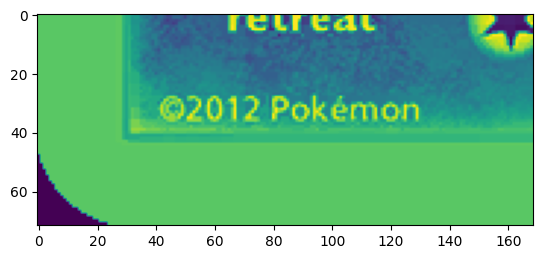

In [12]:
plt.imshow(dataset_df.loc[1,'corner'])

In [102]:
# Sometimes the api refuses us the access because of too many requests -> that was a check

url = 'https://api.pokemontcg.io/v2/cards/swsh9-1'
response = requests.get(url)

In [103]:
response

<Response [429]>

### Cropping using numpy slicing

In [8]:
card_image = np.array(image)

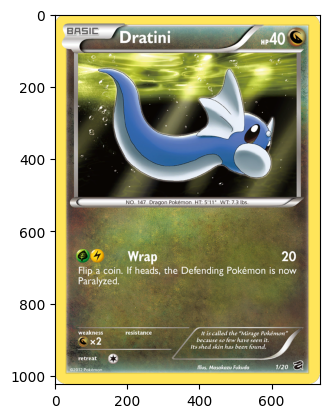

In [9]:
plt.imshow(card_image)

In [17]:
card_image.shape

(1024, 734, 4)

In [24]:
h, w, d = card_image.shape
bottomleft = card_image[h-72:, :184, :]
bottomright = card_image[h-72:, w-184:, :]

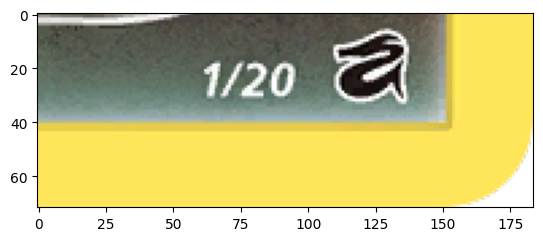

In [25]:
plt.imshow(bottomright)

In [26]:
bottomleft.shape

(72, 184, 4)

In [27]:
bottomright.shape

(72, 184, 4)

### Retrieve the image through image url instead of basic tcg api

In [30]:
image_url = f'https://images.pokemontcg.io/dv1/1_hires.png'

# Send a GET request to the image URL to retrieve the image
response_card = requests.get(image_url)
# Check if the request was successful
if response_card.status_code == 200:
    # Open the image using PIL
    image = Image.open(BytesIO(response_card.content))
    
    # gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Save the image to a file
    # image.save(f"../raw_data/pokemon_cards_api/card_{s_id}_{str(i)}.png")
    # width, height = image.size
    
    # crop bottom corners of the card
    card_image = np.array(image)
    h, w, d = card_image.shape
    bottomleft = card_image[h-72:, :184, :]
    bottomright = card_image[h-72:, w-184:, :]
    graybottomleft = cv2.cvtColor(bottomleft, cv2.COLOR_BGR2GRAY)
    graybottomright = cv2.cvtColor(bottomright, cv2.COLOR_BGR2GRAY)

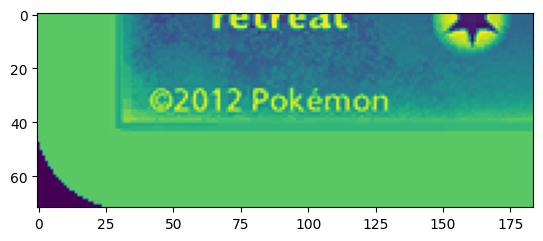

In [32]:
plt.imshow(graybottomleft)

## API call for card info
Checking what are the key word to get card info:
- image url
- rarity
- price

In [1]:
import requests

In [22]:
set_id = 'xy1'
poke_id = '1'

# set_id = 'swsh10'
# poke_id = 8

url = f'https://api.pokemontcg.io/v2/cards/{set_id}-{str(poke_id)}'
response = requests.get(url).json()

response['data']['cardmarket']['prices']['averageSellPrice']


4.49

In [3]:
response['data']['rarity']

'Rare Holo EX'

In [9]:
response['data']['cardmarket']['prices']['averageSellPrice']

3.09

In [5]:
response['data']['images']['large']

'https://images.pokemontcg.io/xy1/1_hires.png'